# Renewable energy sources optimization

### Problem formulation

We want to optimize the distribution of the energy load coming from multiple sources.
We have to satisfy the demand of several customers, and to minimize the overall cost.
Let us take a simplified example, with two renewable energies sources and two customers.

### Parameters

- **Energy Sources**: Solar and Wind, each with different capacities and costs.
  
| Source            | Capacity (kW) | Cost (€/kW) |
|-------------------|---------------|-------------|
| Solar | 100           | 0.15        |                    
|  Wind | 150           | 0.20        |                   

- **Customers**: A & B, each with a specific energy demand.
    - Consumer A: $D_A$ = 90 kW
    - Consumer B: $D_B$ = 120 kW

- **Objective**: Minimize the total cost of energy distribution while meeting all consumer demands without exceeding the source capacities.
  
- An **analytical solution** is possible for a 2x2 problem as well (look [here](https://math.stackexchange.com/questions/4909516/linear-optimization-using-lagrange-multipliers/4909626#4909626))



### Formulation

- **Variables**:
    - $x_{i,a}$: Amount of energy transferred from source $i$ to consumer $a$.
- **Objective**
    We can define a linear cost, to be minimized:
    $$ \text{Cost} = \kappa_s \times (x_{s} + y_{s}) + \kappa_w \times(x_{w} + y_{w}) $$
- **Constraints**
  At any time these constraint must be met:
    1. Total energy supplied to each consumer meets their demand.
        - Demand of Consumer A: $x_{s} + x_{w} = D_A$
        - Demand of Consumer B: $y_{s} + y_{w} = D_B$
    2. The total energy taken from each source does not exceed its capacity.
        - Solar capacity: $x_{s} + y_{s} \leq S_{max}$
        - Wind capacity: $x_{w} + y_{w} \leq W_{max}$
    3. All energies must be positive
       - $x_{i,a} \geq 0$ for any $(i, a)$
         

# EnergySource, Consumer, EnergyDistribution classes

Let us take advantage of three classes to store and validate data

In [1]:
from optimization.core.renewables import EnergySource, Consumer, EnergyDistribution

# Create EnergySource instances
solar = EnergySource("Solar", 150, 0.15)
wind = EnergySource("Wind", 100, 0.2)

# Create Consumer instances
consumer_a = Consumer("A", 90.)
consumer_b = Consumer("B", 120.)

# Create the energy distribution system
system = EnergyDistribution()

system.add_source(solar)
system.add_source(wind)

system.add_consumer(consumer_a)
system.add_consumer(consumer_b)

In [2]:
system.read_max_values()

### Test guess solution

The guess solution is proposed as a numpy array, the first column being the solar demand, and the second one is wind requirement. The row corrsespond to Customers A and B respectively.

We can use the `cost_function` method implemented in the `EnergyDistribution` class.

Note that the `test=True` options trigger the `check_solution_integrity` method which verifies that the problem requirements are satisfied. If a solution does not respect the constraint, an error will be raised.

In [3]:
import numpy as np

guess_solution = np.array([
    [20., 70.],  # >> Customer A 
    [90., 30.],  # >> Customer B
]) 

system.cost_function(guess_solution, test=True)

36.5

# Find optimal solution

We can use `scipy` to find an optimal solution for the problem. We start from an initial guess and quickly arrive to a solution. 

In [4]:
from scipy.optimize import minimize

x = np.array([1., 1., 1., 1.])

# Define Constraints

constraints = [
    {'type': 'ineq', 'fun': lambda x: solar.capacity - x[0::2].sum()}, # Sum of xs and ys should not exceed solar capacity
    {'type': 'ineq', 'fun': lambda x: wind.capacity - x[1::2].sum()},  # Sum of xw and yw should not exceed wind capacity
    {'type': 'eq', 'fun': lambda x: x[0:2].sum() - consumer_a.demand},   # Sum of xs and xw equals consumer_a's demand
    {'type': 'eq', 'fun': lambda x: x[2:4].sum() - consumer_b.demand},   # Sum of ys and yw equals consumer_b's demand
]


In [5]:
# Solve

max_capacity = max( solar.capacity, wind.capacity )

scipy_solution = minimize(
    system.cost_function,  
    x, 
    constraints=constraints,
    bounds = len(x)*[(0,max_capacity)],
    method='SLSQP',
    options={'disp': True,'maxiter' : 1e6}
)

scipy_solution

Optimization terminated successfully    (Exit mode 0)
            Current function value: 34.5
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 34.5
       x: [ 6.750e+01  2.250e+01  8.250e+01  3.750e+01]
     nit: 8
     jac: [ 1.500e-01  2.000e-01  1.500e-01  2.000e-01]
    nfev: 40
    njev: 8

In [6]:
system.check_solution_integrity(scipy_solution.x)

True

In [7]:
xw, xs, yw, ys = scipy_solution.x

In [8]:
xw + xs


90.0

# Visualization

Let us create a set of possible solutions and visualize where `scipy` solution sits.
All solutions mush satisfy the constraints of the problem. Thus, they sit in an area s.t. the demands of each customers are satisfied while the maximum capacity of the source is respected. 

In [9]:
solutions, costs = system.generate_many_solutions(nsolutions=500)

# Get all values to show

xws = [arr[0, 0] for arr in solutions]
xss = [arr[0, 1] for arr in solutions]
yws = [arr[1, 0] for arr in solutions]
yss = [arr[1, 1] for arr in solutions]


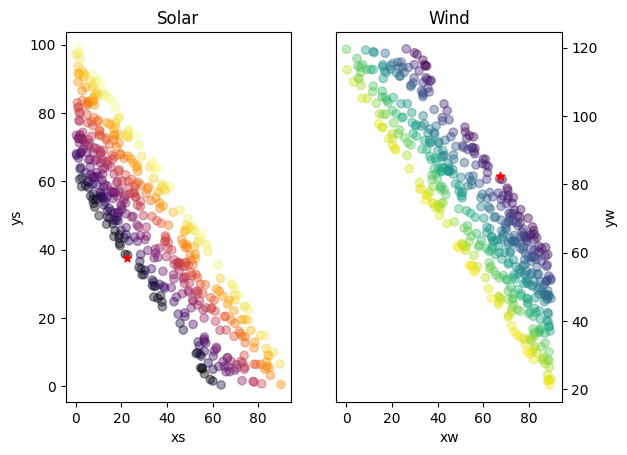

In [10]:
import matplotlib.pyplot as plt

fig, [ax_s, ax_w] = plt.subplots(1, 2)

ax_s.set_title('Solar')
ax_s.scatter( xss, yss, c=costs, cmap ='inferno', alpha=0.4 )

ax_s.set_ylabel('ys')
ax_s.set_xlabel('xs')

ax_w.yaxis.tick_right()
ax_w.yaxis.set_label_position("right")
ax_w.set_title('Wind')
ax_w.scatter( xws, yws, c=costs, cmap ='viridis', alpha=0.4 )

ax_w.set_ylabel('yw')
ax_w.set_xlabel('xw')

ax_w.scatter(xw, yw, c='r', marker='*')
ax_s.scatter(xs, ys, c='r', marker='*')

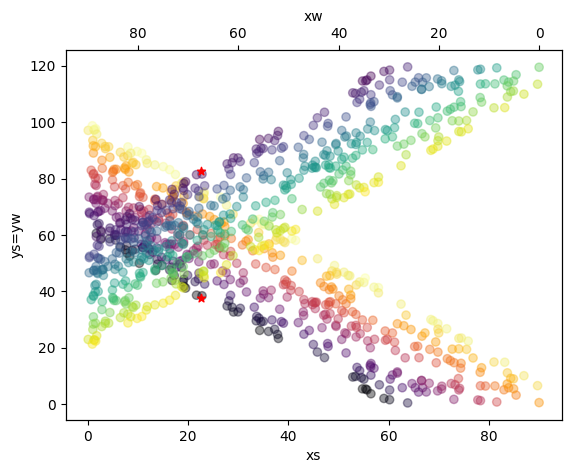

In [11]:
import matplotlib.pyplot as plt

fig, ax_s = plt.subplots()

ax_s.scatter( xss, yss, c=costs, cmap ='inferno', alpha=0.4 )
ax_s.scatter(xs, ys, c='r', marker='*')

ax_s.set_ylabel('ys=yw')
ax_s.set_xlabel('xs')

ax_w = ax_s.twiny()
ax_w.invert_xaxis()
ax_w.scatter( xws, yws, c=costs, cmap ='viridis', alpha=0.4 )

ax_w.set_ylabel('yw')
ax_w.set_xlabel('xw')

ax_w.scatter(xw, yw, c='r', marker='*')

In [12]:
import os
from optimization.config import IMAGES_DIR

output = os.path.join(IMAGES_DIR, 'renewables.jpeg')
fig.savefig(output)